In [1]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sns
import socket
import os
from autoreject import *
from preproc_funcs import *
%load_ext autoreload
%autoreload 1
%matplotlib inline

In [2]:
subjID = 1
day = 2
p = {}
hostname = socket.gethostname()
if hostname == 'syndrome' or hostname == 'zod.psych.nyu.edu' or hostname == 'zod':
    p['datc'] =  '/d/DATC/datc/MD_TMS_EEG'
else:
    p['datc'] =  '/Users/mrugankdake/Documents/Clayspace/EEG_TMS/datc/MD_TMS_EEG'
p['data'] = p['datc'] + '/data'
p['analysis'] = p['datc'] + '/analysis'
p['meta'] = p['datc'] + '/analysis/meta_analysis'
p['EEGData'] = f"{p['datc']}/EEGData/sub{subjID:02d}/day{day:02d}"
p['EEGpy'] = f"{p['datc']}/EEGpy/sub{subjID:02d}/day{day:02d}"

if not os.path.exists(p['EEGpy']):
    os.makedirs(p['EEGpy'])
p['general'] = f"{p['EEGpy']}/sub{subjID:02d}_day{day:02d}"
p['concat'] = f"{p['general']}.vhdr"

In [3]:
raw_data = mne.io.read_raw_brainvision(p['concat'], preload=True)
raw_data.drop_channels(['LM', 'RM', 'TP9', 'TP10'])
montage = mne.channels.make_standard_montage("easycap-M1")
raw_data.set_montage(montage)
raw_data.filter(l_freq=0.5, h_freq=55)

events, _ = mne.events_from_annotations(raw_data)
events_dict = {
    'blockonset': 1001,
    'blockend': 8,
    'fixation': 1,
    'delay1': 2,
    'delay2': 3,
    'response': 4,
    'feedback': 6,
    'iti': 7,
    'proinPF': 11,
    'prooutPF': 12,
    'antiinPF': 13,
    'antioutPF': 14
}
trl_events = {
    'proinPF': 11,
    'prooutPF': 12,
    'antiinPF': 13,
    'antioutPF': 14
}

Extracting parameters from /Users/mrugankdake/Documents/Clayspace/EEG_TMS/datc/MD_TMS_EEG/EEGpy/sub01/day02/sub01_day02.vhdr...
Setting channel info structure...
Reading 0 ... 4036319  =      0.000 ...  4036.319 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


Used Annotations descriptions: ['Response/R  1', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14']


[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    4.3s finished


In [4]:
rej_thresh = get_rejection_threshold(raw_data)

TypeError: get_data() got an unexpected keyword argument 'copy'

In [4]:
raw_data = mne.add_reference_channels(raw_data, ref_channels='Cz')
raw_data.set_eeg_reference(ref_channels="average")
# rr = raw_data.plot(start=events[1, 0]/1000+1000, duration = 10, remove_dc=False)
# rr = raw_data_reref.plot(start=events[1, 0]/1000+1000, duration = 10, remove_dc=False)

/var/folders/0w/p5w49zc93976_p2hxj1zws2w0000gn/T/ipykernel_27340/96832509.py:1: RuntimeWarning: The locations of multiple reference channels are ignored.
  raw_data = mne.add_reference_channels(raw_data, ref_channels='Cz')


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawBrainVision | sub01_day02.eeg, 62 x 4036320 (4036.3 s), ~1.86 GB, data loaded>

Not setting metadata
2820 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


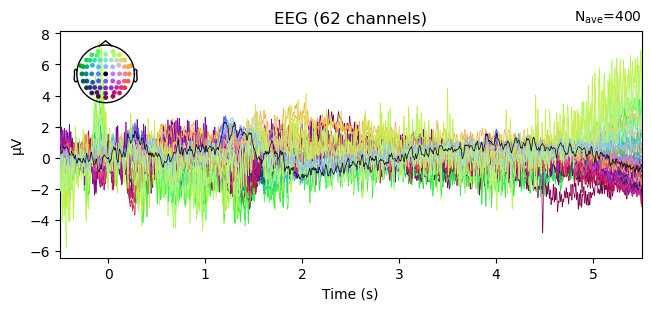

In [5]:
raw2 = raw_data.copy()
raw2.info["bads"] = []
#events = mne.find_events(raw2, stim_channel="STI 014")
epochs = mne.Epochs(raw2, events=events, tmin=-0.5, tmax=5.5)["1"].average().plot()

Effective window size : 2.048 (s)
Effective window size : 18.618 (s)


/opt/anaconda3/envs/eegmne/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/opt/anaconda3/envs/eegmne/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


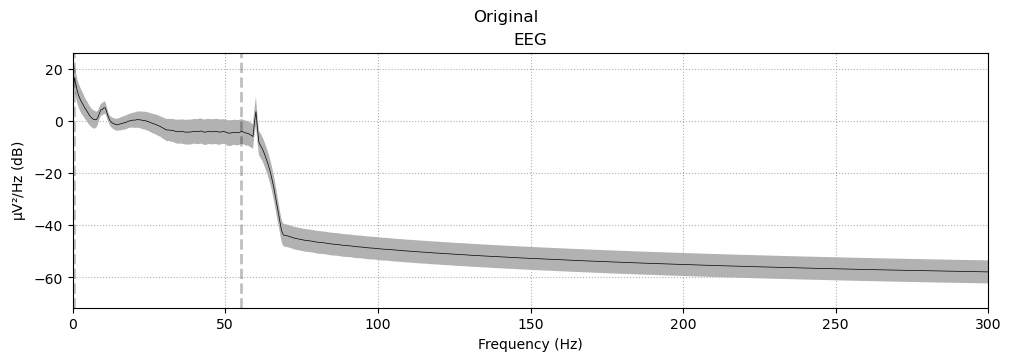

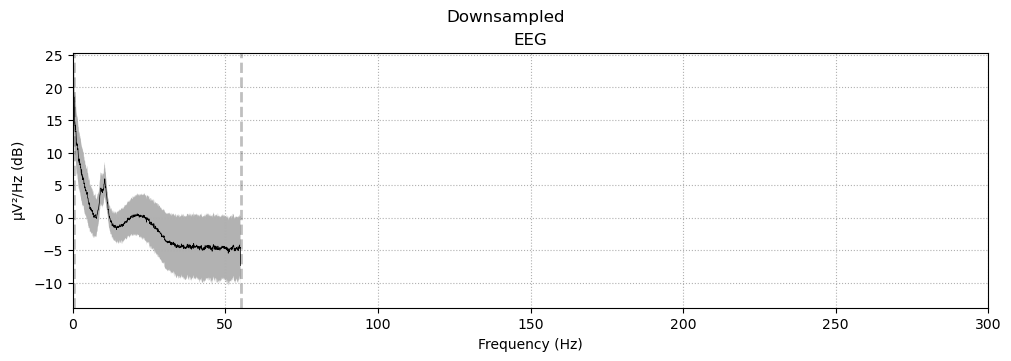

In [6]:
raw_downsampled = raw_data.copy().resample(sfreq=110)

for data, title in zip([raw_data, raw_downsampled], ["Original", "Downsampled"]):
    fig = data.compute_psd().plot(average=True, picks="data", exclude="bads")
    fig.suptitle(title)
    plt.setp(fig.axes, xlim=(0, 300))

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 106.4s.


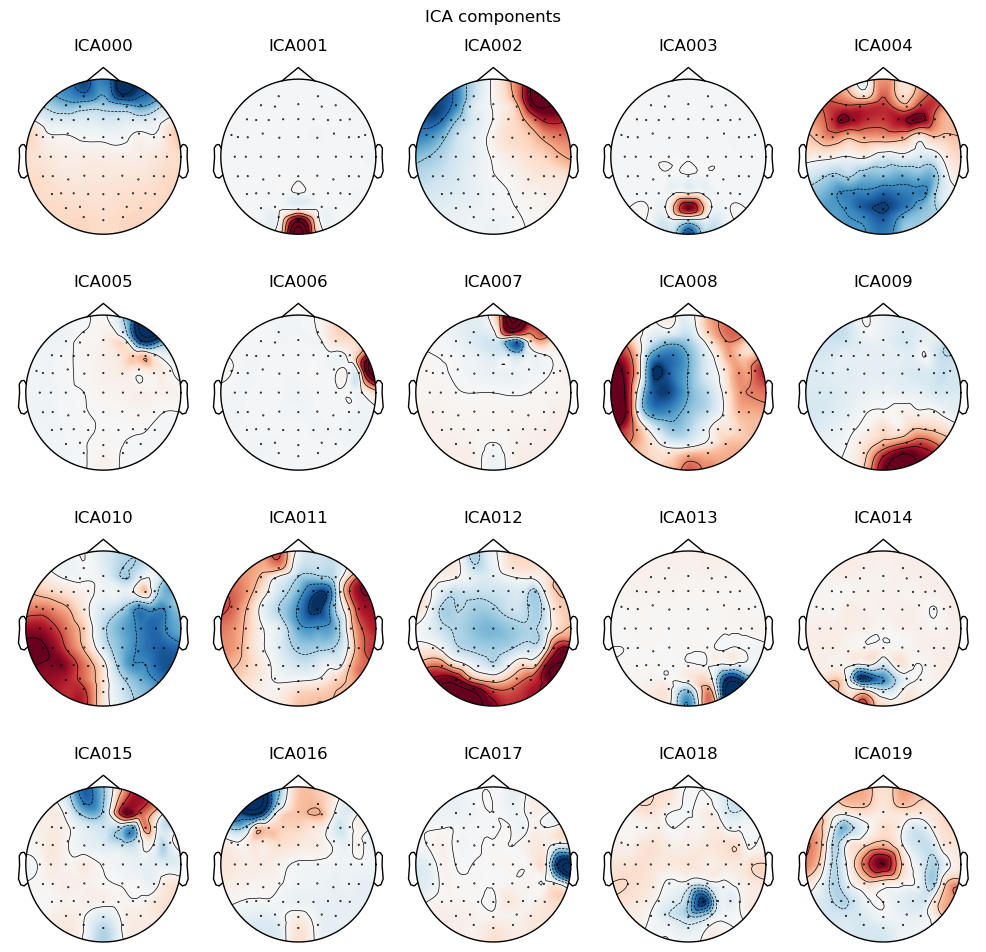

Creating RawArray with float64 data, n_channels=20, n_times=4036320
    Range : 0 ... 4036319 =      0.000 ...  4036.319 secs
Ready.


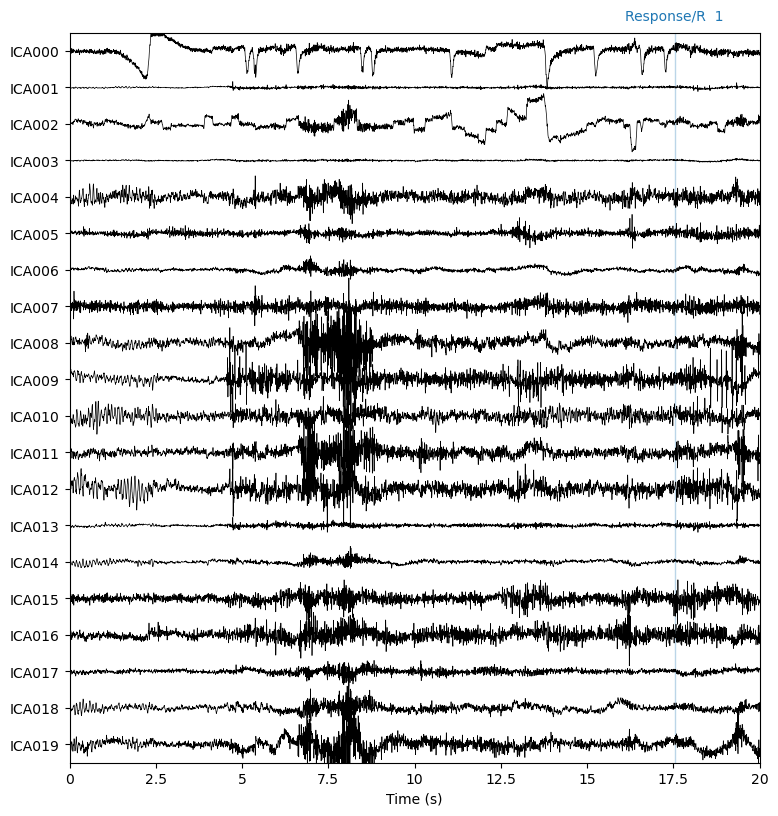

In [14]:
ica = mne.preprocessing.ICA(n_components=20, random_state=42)
ica.fit(raw_data.copy())
ic_plot = ica.plot_components()
ic_plot = ica.plot_sources(raw_data, show_scrollbars=False)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
2018 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2018 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2018 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2018 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2018 matching events found
No baseline correction applied
0 projection items activated


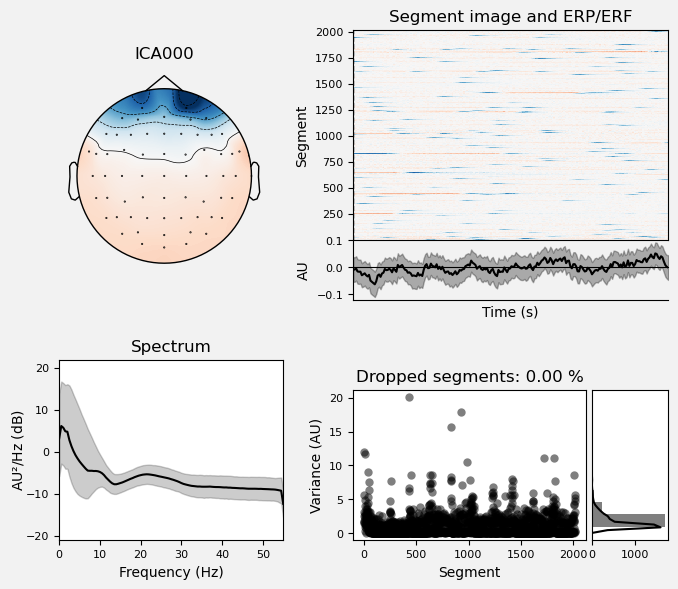

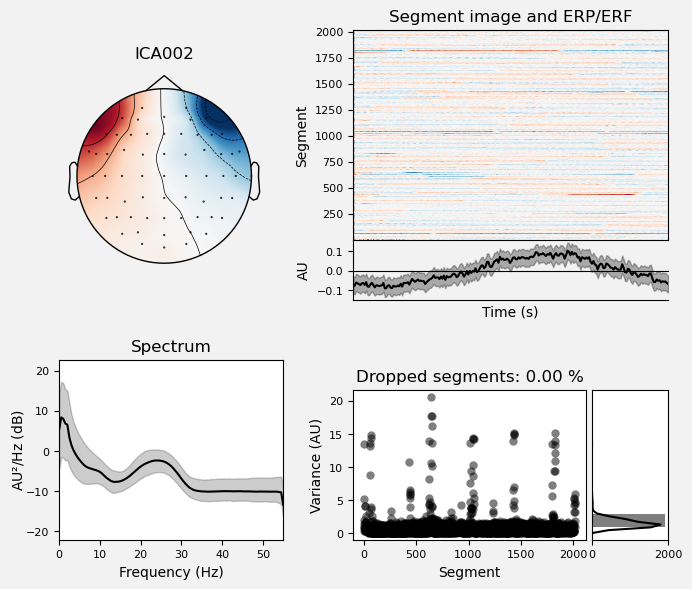

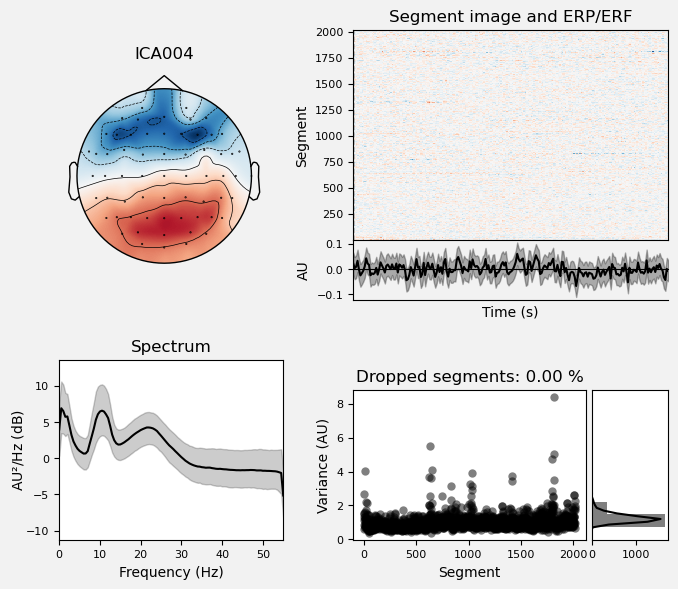

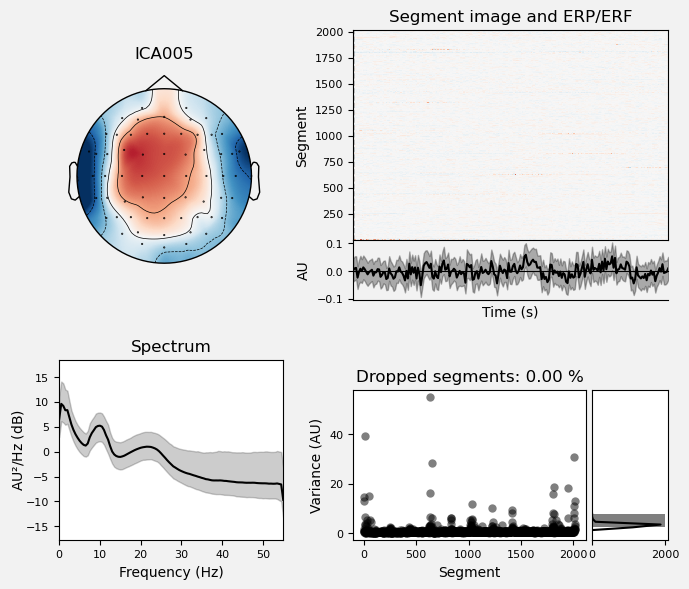

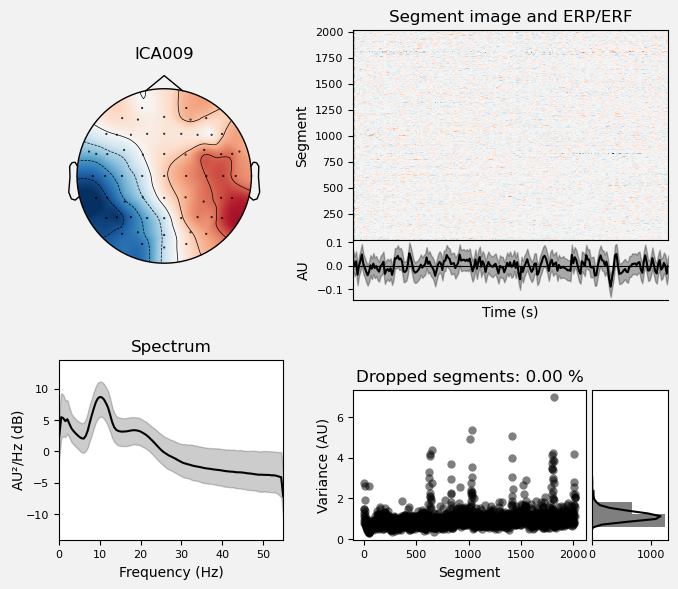

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [8]:
ica.plot_properties(raw_data, picks=[0, 2, 4, 5, 9])

In [9]:
ica.exclude = [0, 2]
#ica.plot_properties(raw_data, picks=ica.exclude)

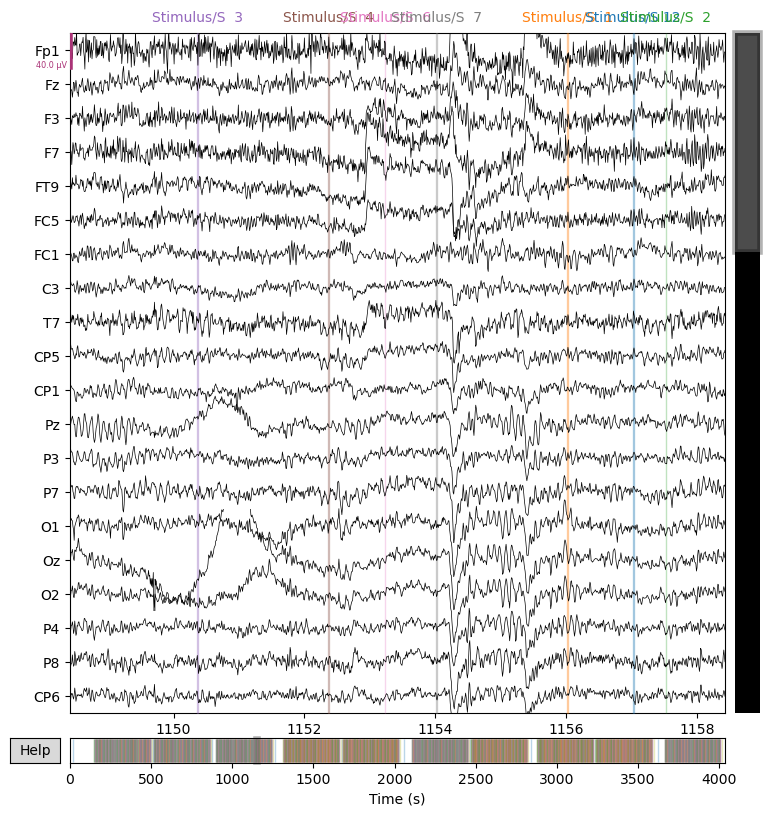

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 62 PCA components


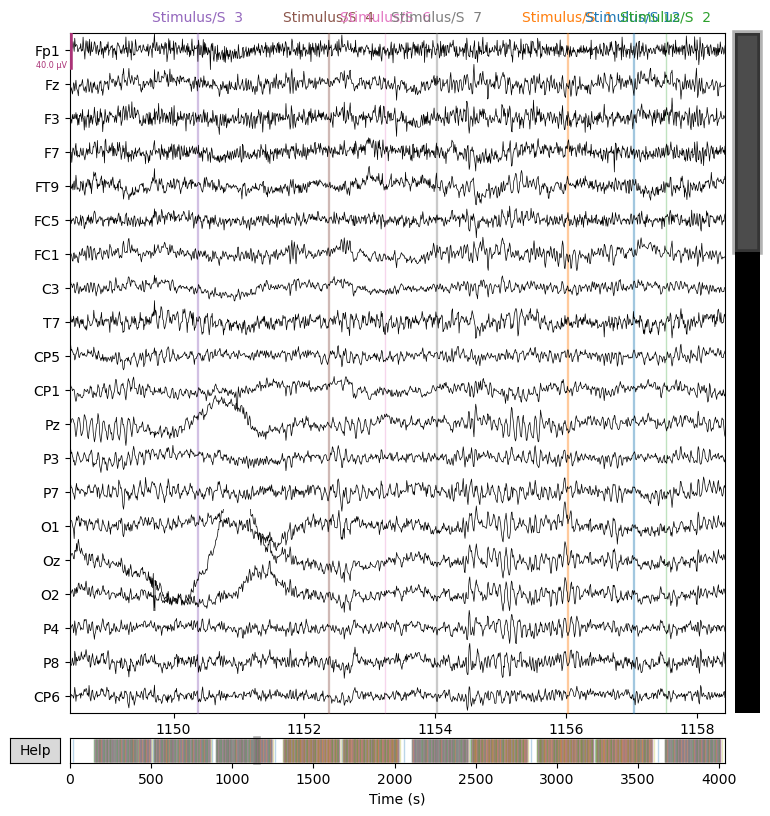

In [10]:
rr = raw_downsampled.plot(start=events[1, 0]/1000+1000, duration = 10, remove_dc=True)
rr = ica.apply(raw_downsampled.copy(), exclude=ica.exclude).plot(start=events[1, 0]/1000+1000, duration = 10, remove_dc=False)

Not setting metadata
400 matching events found


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 400 events and 606 original time points ...
366 bad epochs dropped
Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 62 PCA components


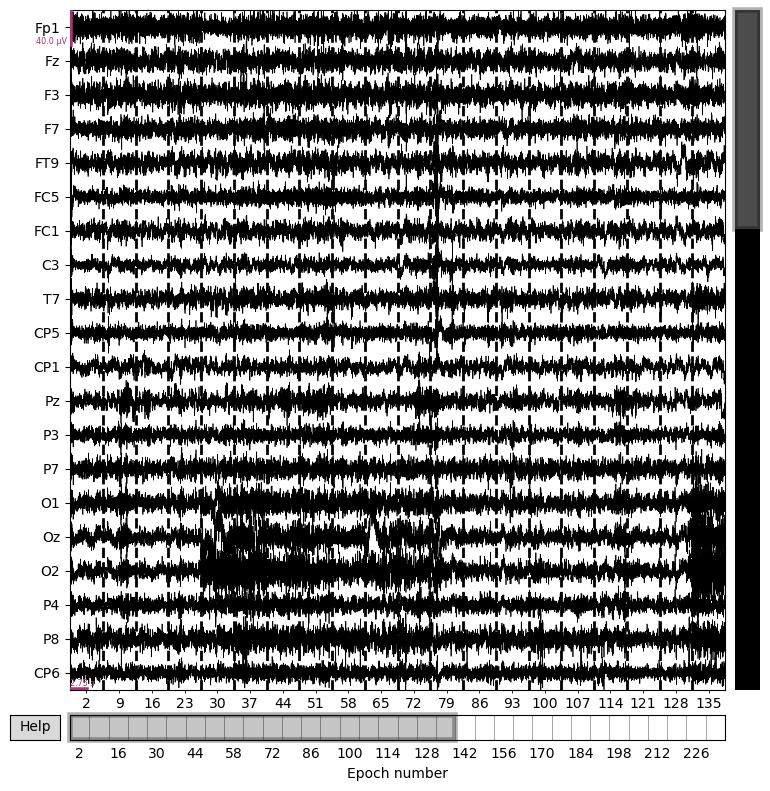

In [11]:
epoched_data = mne.Epochs(
    raw_downsampled, 
    events, 
    event_id=trl_events, 
    # tmin = -1.5,
    # tmax = 5.5,
    tmin=-1,
    tmax=4.5,
    baseline=None, 
    preload=True
)
epoched_data = ica.apply(epoched_data.copy(), exclude=ica.exclude)
b = epoched_data.plot()

In [13]:
epoched_data

<Epochs |  34 events (all good), -1 – 4.5 s, baseline off, ~9.8 MB, data loaded,
 'proinPF': 19
 'prooutPF': 15
 'antiinPF': 0
 'antioutPF': 0>

In [12]:
proinPF = epoched_data['proinPF']
prooutPF = epoched_data['prooutPF']
antiinPF = epoched_data['antiinPF']
antioutPF = epoched_data['antioutPF']
proinPF_evoked = proinPF.average()
prooutPF_evoked = prooutPF.average()
antiinPF_evoked = antiinPF.average()
antioutPF_evoked = antioutPF.average()

RuntimeError: epochs.average() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.

    Using multitaper spectrum estimation with 7 DPSS windows


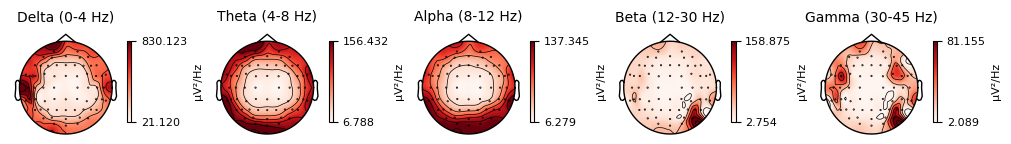

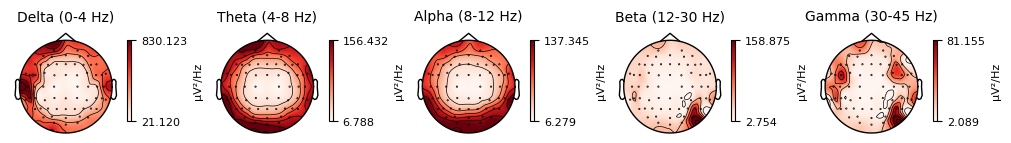

In [47]:
proinPF_spectrum = proinPF.compute_psd()
proinPF_spectrum.plot_topomap()

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated


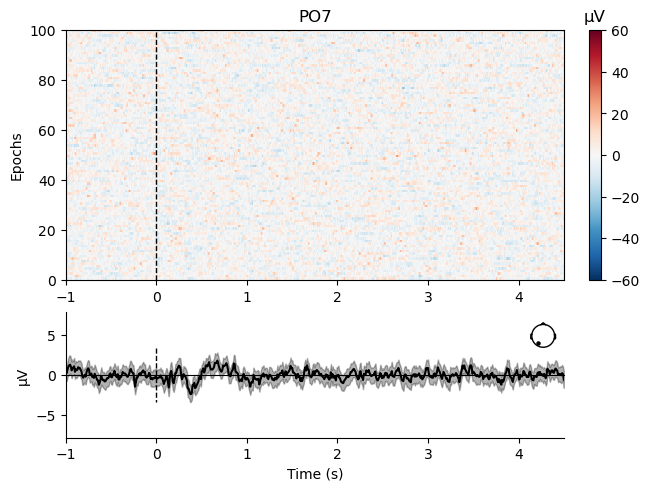

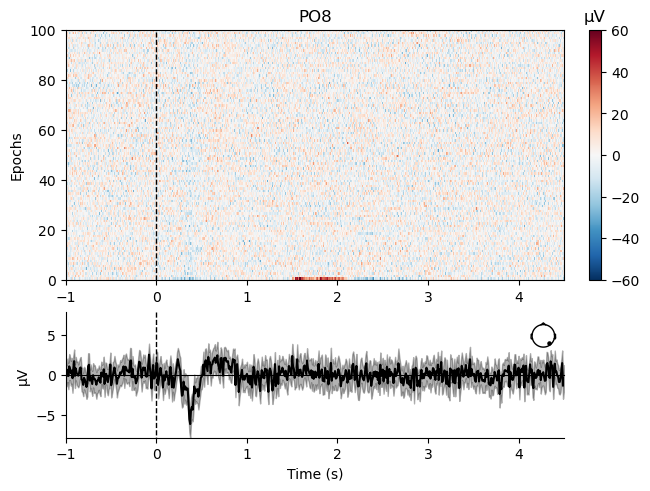

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [46]:
prooutPF.plot_image(picks=["PO7", "PO8"])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


No baseline correction applied


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    4.6s finished


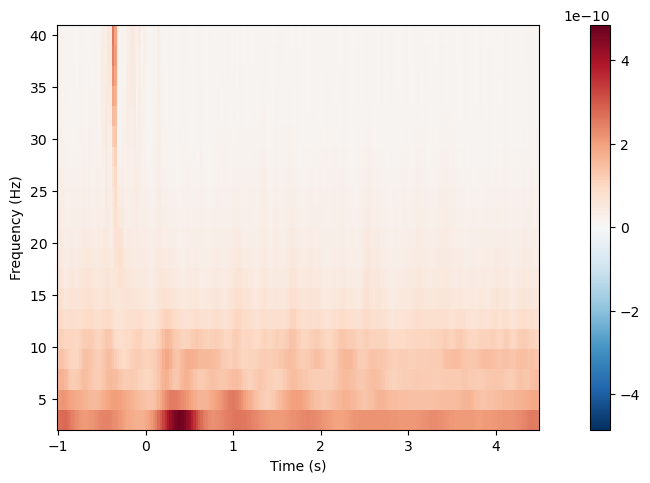

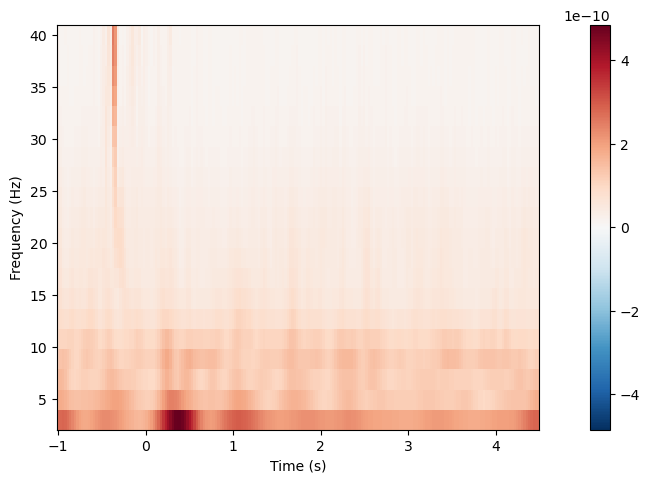

In [20]:
frequencies = np.linspace(3, 40, 20)
power = mne.time_frequency.tfr_morlet(
    proinPF, n_cycles=4, return_itc=False, freqs=frequencies, decim=3
)

aa = power.plot(["O1", "O2"])

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


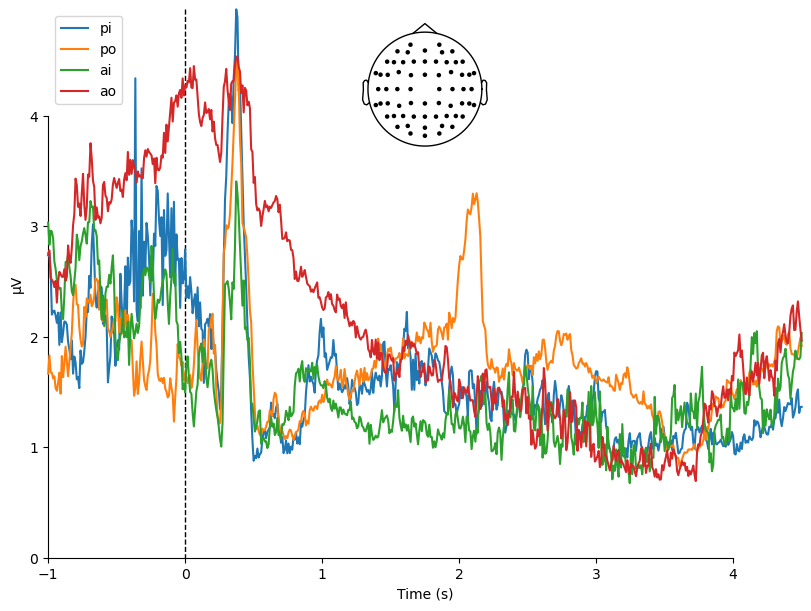

In [21]:
aa = mne.viz.plot_compare_evokeds(
    dict(pi=proinPF_evoked, po=prooutPF_evoked, ai=antiinPF_evoked, ao=antioutPF_evoked),
    legend="upper left",
    show_sensors="upper center"
)

In [ ]:
proinPF_evoked.plot_joint()